In [1]:
import numpy as np
import pandas as pd
from scipy.stats import chi2
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
from matplotlib.patches import Ellipse, Rectangle, Circle, Wedge
from IPython.display import clear_output
import time
from data_processing_13_part3_model import compute_smoothed_trajectory, process_ekf_segments, extract_observations, get_current_observations, get_trajectory_for_time, create_uncertainty_ellipse

In [3]:
file_path = './Synched_Data_GR0_22_DEN_MAXZ1_25/NEWDATA/'
file_date = ['101922', '102122', '111422', '111622', '120522', '120722', '013023', '020123', '031323', '031523', '041723', '041923', '061523']
date = file_date[0]

file_name = f'DAYUBIGR_{date}_GR0_22_DEN_032825_V2392628911.CSV'
full_path = file_path + file_name

raw_data = pd.read_csv(full_path, header=None, names=['SUBJECTID', 'TIME', 'X', 'Y', 'Z'])
clear_data = raw_data.reset_index(drop=True)
clear_data = clear_data[(clear_data["X"] <= 15) & (clear_data["Y"] <= 9) & 
                        (clear_data["X"] >= 0) & (clear_data["Y"] >= 0)].copy()
target_subject_base = "DS_STARFISH_2223_27"
subject_data = clear_data[clear_data['SUBJECTID'].str.startswith(target_subject_base)].copy()
subject_data['side'] = subject_data['SUBJECTID'].str.extract(r'(\d+[LR])$')[0].str[-1].map({'L': 'left', 'R': 'right'})


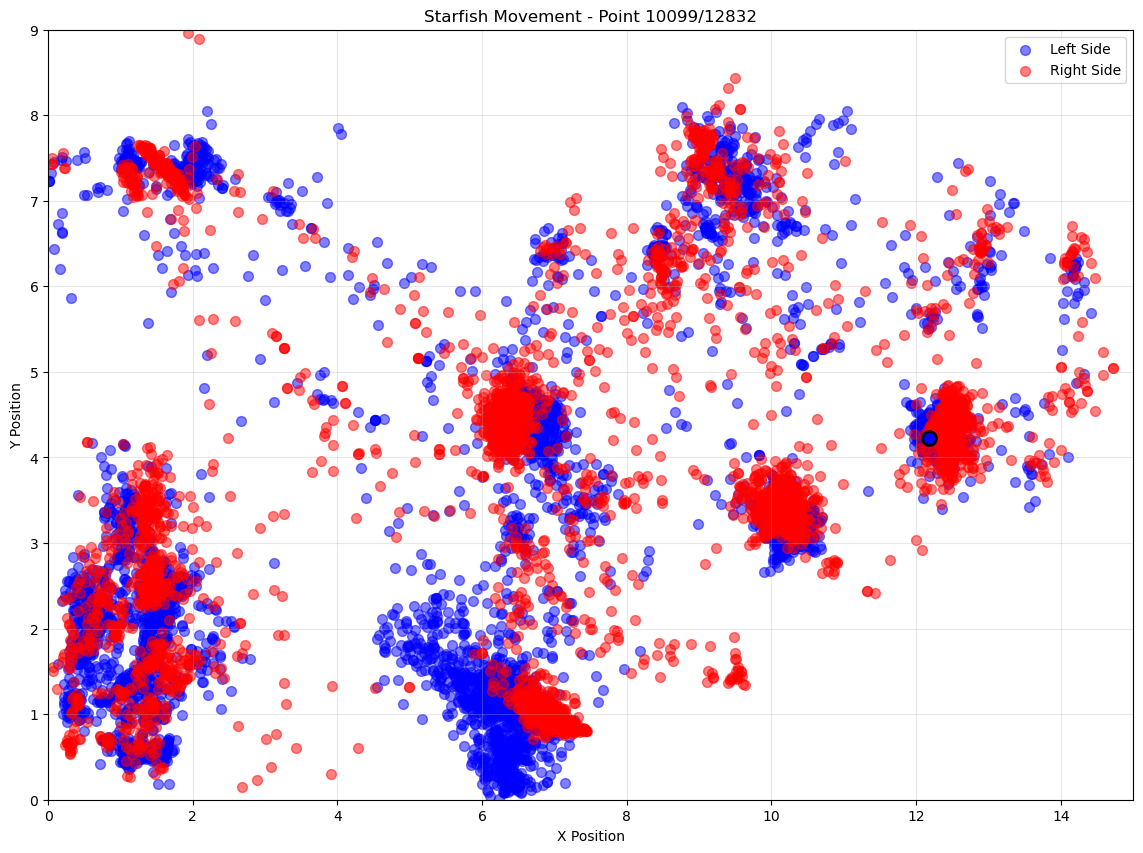

In [ ]:
# The chart has both right and left side data points

def create_jupyter_animation(subject_data):
    
    data_sorted = subject_data.sort_values('TIME').reset_index(drop=True)
    step = 1
    
    for i in range(0, len(data_sorted), step):
        clear_output(wait=True)
        
        current_data = data_sorted.iloc[:i+1]
        
        plt.figure(figsize=(14, 10))
        left_data = current_data[current_data['side'] == 'left']
        right_data = current_data[current_data['side'] == 'right']
        
        if len(left_data) > 0:
            plt.scatter(left_data['X'], left_data['Y'], c='blue', s=50, alpha=0.5, label='Left Side')
        
        if len(right_data) > 0:
            plt.scatter(right_data['X'], right_data['Y'], c='red', s=50, alpha=0.5, label='Right Side')
        
        if i < len(data_sorted):
            current_point = data_sorted.iloc[i]
            color = 'blue' if current_point['side'] == 'left' else 'red'
            plt.scatter(current_point['X'], current_point['Y'], c=color, s=100, alpha=1.0, edgecolors='black', linewidth=2, marker='o')
        
        plt.xlim(0, 15)
        plt.ylim(0, 9)
        plt.xlabel('X Position')
        plt.ylabel('Y Position')
        plt.title(f'Starfish Movement - Point {i+1}/{len(data_sorted)}')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        plt.show()
        time.sleep(0.05)

create_jupyter_animation(subject_data)

In [ ]:
# The charts have right and left side data points animated in different subplots

def separate_animation(subject_data):

    data_sorted = subject_data.sort_values('TIME').reset_index(drop=True)
    step = 1

    fig, axs = plt.subplots(1, 2, figsize=(14, 8), sharex=True, sharey=True)

    for i in range(0, len(data_sorted), step):
        clear_output(wait=True)

        # Clear previous plots
        for ax in axs:
            ax.clear()
            ax.set_xlim(0, 15)
            ax.set_ylim(0, 9)
            ax.set_xlabel('X Position')
            ax.set_ylabel('Y Position')
            ax.grid(True, alpha=0.3)

        current_data = data_sorted.iloc[:i+1]

        # Left
        left_data = current_data[current_data['side'] == 'left']
        axs[0].scatter(left_data['X'], left_data['Y'], c='red', s=50, alpha=0.5, label='Left')
        if not current_data.empty and current_data.iloc[-1]['side'] == 'left':
            point = current_data.iloc[-1]
            axs[0].scatter(point['X'], point['Y'], c='red', s=100, edgecolors='black', linewidth=2, marker='o')
        axs[0].legend()
        axs[0].set_title(f'Left Side Movement')

        # Right
        right_data = current_data[current_data['side'] == 'right']
        axs[1].scatter(right_data['X'], right_data['Y'], c='blue', s=50, alpha=0.5, label='Right')
        if not current_data.empty and current_data.iloc[-1]['side'] == 'right':
            point = current_data.iloc[-1]
            axs[1].scatter(point['X'], point['Y'], c='blue', s=100, edgecolors='black', linewidth=2, marker='o')
        axs[1].legend()
        axs[1].set_title(f'Right Side Movement')

        plt.tight_layout()
        display(fig)
        time.sleep(0.05)

separate_animation(subject_data) 

In [ ]:
# The chart of EKF smoothed trajectory only

def ekf_trajectory_animation(subject_data, final_params=[0.06787, 0.08011, 0.04829, 0.38712, 0.41107], dt_virt=0.5, save_gif=False, gif_filename='ekf__animation.gif'):
    
    s_smooth = compute_smoothed_trajectory(subject_data, final_params, dt_virt)
    
    subject_data_processed = subject_data.copy()
    subject_data_processed['TIME'] = pd.to_datetime(subject_data_processed['TIME'])
    t0 = subject_data_processed['TIME'].min()
    subject_data_processed['timestamp'] = (subject_data_processed['TIME'] - t0).dt.total_seconds()

    timestamps = subject_data_processed['timestamp'].values
    virtual_ts = np.arange(min(timestamps), max(timestamps), dt_virt)
    
    data_sorted = subject_data.sort_values('TIME').reset_index(drop=True)
    
    fig, ax = plt.subplots(figsize=(15, 9))

    step = 10
    
    def animate(frame):
            for i in range(0, len(data_sorted), step):
                clear_output(wait=True)
                
                ax.clear()
                ax.set_xlim(0, 15)
                ax.set_ylim(0, 9)
                ax.set_xlabel('X Position')
                ax.set_ylabel('Y Position')
                ax.grid(True, alpha=0.3)
                ax.set_title('EKF Smoothed Trajectory')
                
                current_data = data_sorted.iloc[:i+1]
                current_time = current_data.iloc[-1]['TIME'] if not current_data.empty else data_sorted.iloc[0]['TIME']
                
                current_timestamp = (pd.to_datetime(current_time) - t0).total_seconds()
                
                ekf_idx = np.searchsorted(virtual_ts, current_timestamp)
                ekf_idx = min(ekf_idx, len(s_smooth) - 1)
                
                # Show raw sensor data up to current time
                left_data = current_data[current_data['side'] == 'left']
                right_data = current_data[current_data['side'] == 'right']
                
                ax.scatter(left_data['X'], left_data['Y'], c='red', s=30, alpha=0.4, label='Left Sensor')
                ax.scatter(right_data['X'], right_data['Y'], c='blue', s=30, alpha=0.4, label='Right Sensor')
                
                if ekf_idx > 0:
                    x_coords = [s[0] for s in s_smooth[:ekf_idx+1]]
                    y_coords = [s[1] for s in s_smooth[:ekf_idx+1]]
                    
                    ax.plot(x_coords, y_coords, 'g-', linewidth=2, label='EKF Trajectory')
                    
                    if ekf_idx < len(s_smooth):
                        current_x, current_y = s_smooth[ekf_idx][0], s_smooth[ekf_idx][1]
                        ax.scatter(current_x, current_y, c='green', s=150, edgecolors='black', linewidth=2, marker='o', zorder=5)
                
                ax.legend()
                display(fig)
                time.sleep(0.01)

    frames = range(0, len(data_sorted), step)
    ani = animation.FuncAnimation(fig, animate, frames=frames, interval=100, repeat=True)

    if save_gif:
        ani.save(gif_filename, writer='pillow', fps=10)
    
    return ani

ekf_trajectory_animation(subject_data, save_gif=False)

### Check the consistency of the time stamps for both sensor data and ekf smoothed trajectory
### Add furniture plot in the chart
### Rethink about the structure of the ekf filter on the data: 1. same model for the entire data; 2. loop the filter on time segments separately
### Figure out the multi processing method
### Visualize the facing angle
### Rerun EKF with loops and UKF with packages
#### keep the state_mean function, for angle, can modify:
##### def residual(a, b):
#####    y = a[0] - b[0]
#####    if y == np.pi:
#####        y -= 2*np.pi
#####    while ... y < -np.pi:
#####        y = 2*np.pi
#####    return y

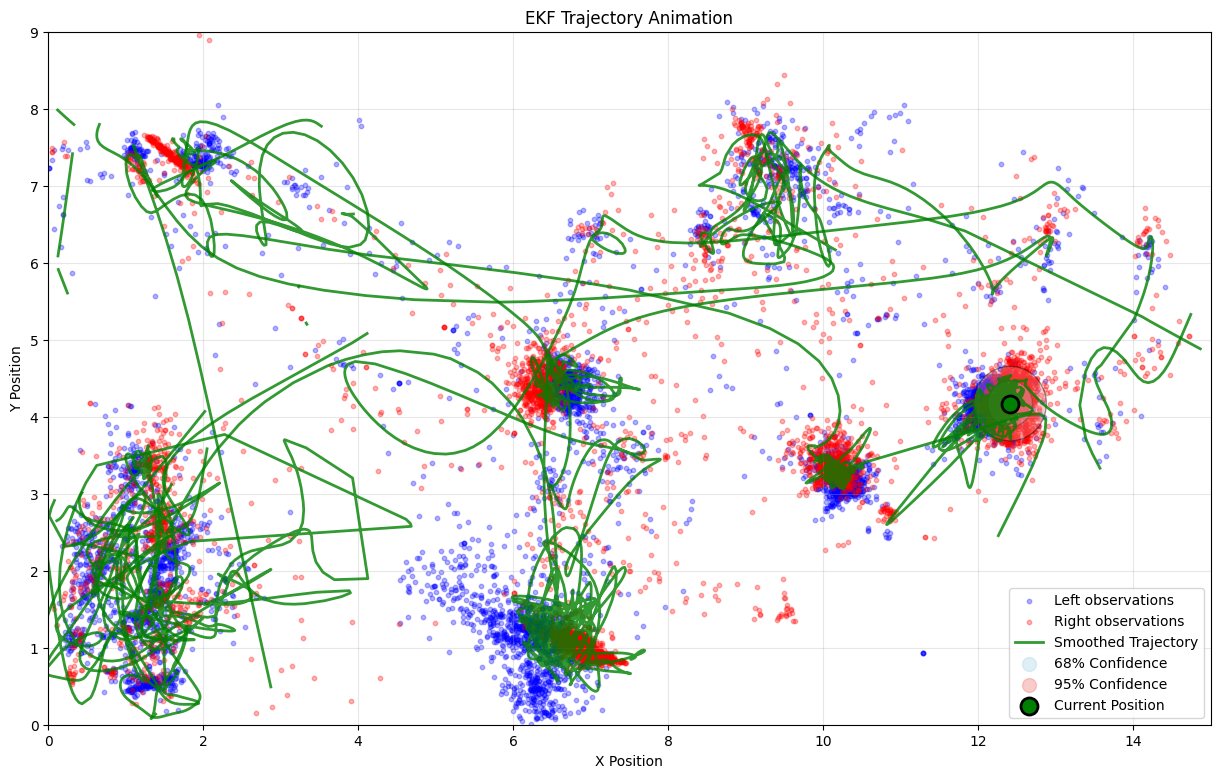

In [7]:
# The chart of EKF smoothed trajectory with time segments

def ekf_trajectory_animation(subject_data, 
                           final_params=[0.06787, 0.08011, 0.04829, 0.38712, 0.41107], 
                           dt_virt=0.5, 
                           save_gif=False, 
                           gif_filename='ekf_animation.gif', 
                           show_uncertainty=True, 
                           confidence_levels=[0.68, 0.95],
                           time_step=5,
                           xlim=(0, 15),
                           ylim=(0, 9)):

    real_data, time_segments = compute_smoothed_trajectory(subject_data, final_params, dt_virt)   
    segment_trajectories = process_ekf_segments(time_segments, final_params, dt_virt)

    (left_x, left_y), (right_x, right_y) = extract_observations(real_data)
    
    all_timestamps = [entry['timestamp'] for entry in real_data]
    min_time, max_time = min(all_timestamps), max(all_timestamps)
    animation_times = np.arange(min_time, max_time + time_step, time_step)
    
    fig, ax = plt.subplots(figsize=(15, 9))
    colors = ['lightblue', 'lightcoral', 'lightgreen']
    
    def animate_frame(frame):
        current_time = animation_times[frame]
        ax.clear()
        ax.set_title(f'EKF Trajectory Animation')
        ax.set_xlabel('X Position')
        ax.set_ylabel('Y Position')
        ax.grid(True, alpha=0.3)
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        
        (current_left_x, current_left_y), (current_right_x, current_right_y) = get_current_observations(real_data, current_time)
        
        if current_left_x:
            ax.scatter(current_left_x, current_left_y, color='blue', alpha=0.3, s=10, label='Left observations')
        if current_right_x:
            ax.scatter(current_right_x, current_right_y, color='red', alpha=0.3, s=10, label='Right observations')
        
        trajectory_data, current_position, current_covariance = get_trajectory_for_time(segment_trajectories, current_time)
        
        first_trajectory = True
        for traj in trajectory_data:
            label = 'Smoothed Trajectory' if first_trajectory else None
            first_trajectory = False
            ax.plot(traj['x'], traj['y'], 'g-', alpha=0.8, linewidth=2, label=label)
        
        if show_uncertainty and current_position and current_covariance is not None:
            for j, conf_level in enumerate(confidence_levels):
                ellipse_params = create_uncertainty_ellipse(current_position, current_covariance, conf_level)
                
                ellipse = Ellipse(xy=ellipse_params['center'],
                                width=ellipse_params['width'], 
                                height=ellipse_params['height'],
                                angle=ellipse_params['angle'],
                                facecolor=colors[j % len(colors)], 
                                alpha=0.4, 
                                edgecolor='black', 
                                linewidth=1.0)
                ax.add_patch(ellipse)
        
        if show_uncertainty:
            for j, conf_level in enumerate(confidence_levels):
                ax.scatter([], [], color=colors[j % len(colors)], alpha=0.4, s=100, 
                          label=f'{conf_level*100:.0f}% Confidence')
        
        if current_position:
            ax.scatter(current_position[0], current_position[1], c='green', s=150, 
                      edgecolors='black', linewidth=2, marker='o', zorder=5, 
                      label='Current Position')
        
        ax.legend()
    
    ani = animation.FuncAnimation(fig, animate_frame, frames=len(animation_times), interval=50, repeat=True, blit=False)
    ani.save(gif_filename, writer='pillow', fps=10)
    
    return ani


ani = ekf_trajectory_animation(subject_data, confidence_levels=[0.68, 0.95], time_step=5)

plt.show()

KeyboardInterrupt: 

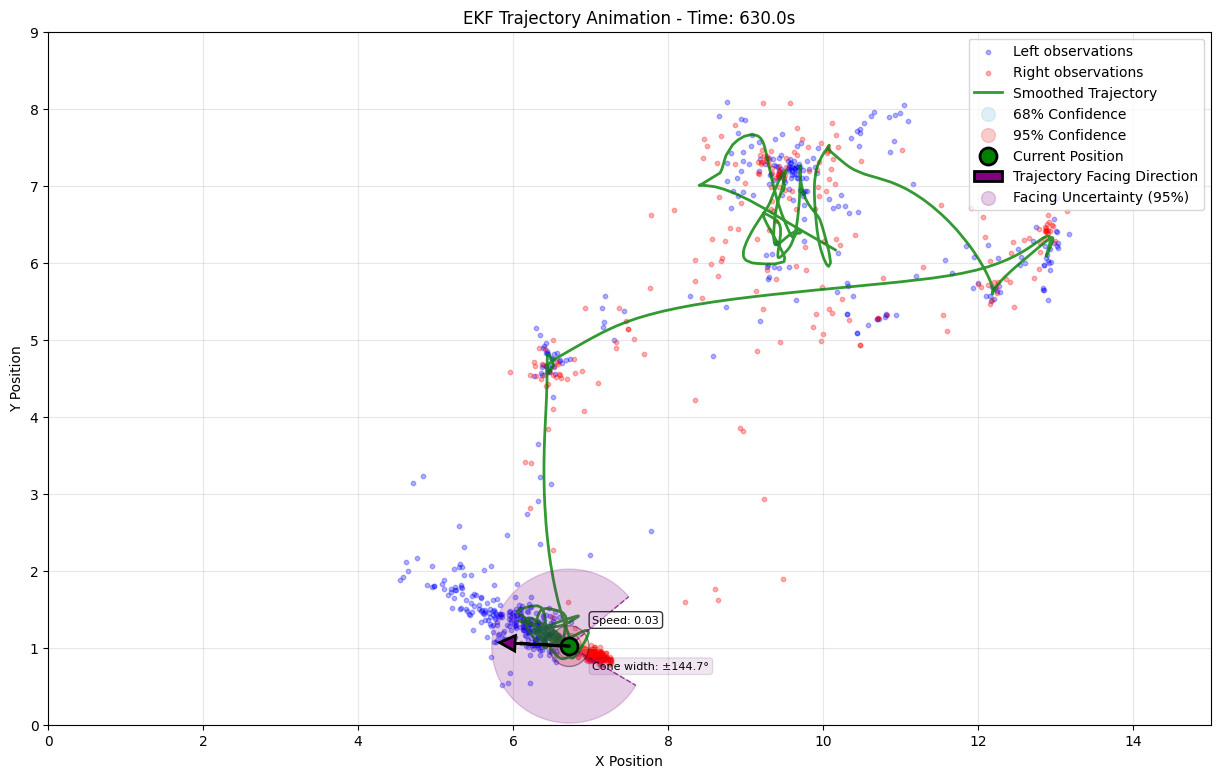

In [ ]:
def get_trajectory_velocity_at_time(segment_trajectories, current_time):

    for segment in segment_trajectories:
        if segment['start_time'] <= current_time <= segment['end_time']:
            # Find the closest timestamp in this segment
            all_ts = np.array(segment['all_ts'])
            closest_idx = np.argmin(np.abs(all_ts - current_time))
            
            if closest_idx < len(segment['trajectory']):
                state = segment['trajectory'][closest_idx]
                covariance = segment['covariances'][closest_idx] if closest_idx < len(segment['covariances']) else None
                
                # Extract velocity components (assuming state = [x, y, theta, vx, vy, omega])
                if len(state) >= 4:
                    vx, vy = state[3], state[4]
                    velocity = np.array([vx, vy])
                    
                    # Extract velocity covariance (vx, vy components)
                    vel_cov = None
                    if covariance is not None and covariance.shape[0] >= 5:
                        vel_cov = covariance[3:5, 3:5]  # 2x2 velocity covariance matrix
                    
                    return velocity, vel_cov
    
    return None, None

def compute_facing_direction_uncertainty(velocity, vel_covariance, confidence_level=0.68, n_samples=100):
    if vel_covariance is None or np.linalg.norm(velocity) < 0.01:
        return None
    
    # Generate samples from the velocity distribution
    try:
        velocity_samples = np.random.multivariate_normal(velocity, vel_covariance, n_samples)
    except np.linalg.LinAlgError:
        # Handle singular covariance matrix
        return None
    
    # Convert velocity samples to angles
    angles = []
    for vel_sample in velocity_samples:
        if np.linalg.norm(vel_sample) > 0.01:  # Only consider non-zero velocities
            angle = np.arctan2(vel_sample[1], vel_sample[0])
            angles.append(angle)
    
    if len(angles) < 10:  # Not enough valid samples
        return None
    
    angles = np.array(angles)
    
    mean_angle = np.arctan2(velocity[1], velocity[0])
    
    # Unwrap angles relative to mean
    angles_unwrapped = angles.copy()
    for i in range(len(angles)):
        while angles_unwrapped[i] - mean_angle > np.pi:
            angles_unwrapped[i] -= 2*np.pi
        while angles_unwrapped[i] - mean_angle < -np.pi:
            angles_unwrapped[i] += 2*np.pi
    
    # Compute confidence interval
    percentile_low = (1 - confidence_level) / 2 * 100
    percentile_high = (1 + confidence_level) / 2 * 100
    
    angle_low = np.percentile(angles_unwrapped, percentile_low)
    angle_high = np.percentile(angles_unwrapped, percentile_high)
    
    return {
        'mean_angle': mean_angle,
        'angle_low': angle_low,
        'angle_high': angle_high,
        'cone_width': angle_high - angle_low,
        'sample_angles': angles
    }

def ekf_trajectory_animation(subject_data, 
                           final_params=[0.06787, 0.08011, 0.04829, 0.38712, 0.41107], 
                           dt_virt=0.5, 
                           save_gif=False, 
                           gif_filename='ekf_animation.gif', 
                           show_uncertainty=True, 
                           confidence_levels=[0.68, 0.95],
                           time_step=10,
                           xlim=(0, 15),
                           ylim=(0, 9),
                           show_facing_uncertainty=True,
                           facing_confidence_level=0.68):
    
    real_data, time_segments = compute_smoothed_trajectory(subject_data, final_params, dt_virt)   
    segment_trajectories = process_ekf_segments(time_segments, final_params, dt_virt)

    # Extract observations - handle different return formats
    (left_x, left_y), (right_x, right_y) = extract_observations(real_data)
    
    all_timestamps = [entry['timestamp'] for entry in real_data]
    min_time, max_time = min(all_timestamps), max(all_timestamps)
    animation_times = np.arange(min_time, max_time + time_step, time_step)
    
    fig, ax = plt.subplots(figsize=(15, 9))
    colors = ['lightblue', 'lightcoral', 'lightgreen']
    
    def animate_frame(frame):
        current_time = animation_times[frame]
        ax.clear()
        ax.set_title(f'EKF Trajectory Animation - Time: {current_time:.1f}s')
        ax.set_xlabel('X Position')
        ax.set_ylabel('Y Position')
        ax.grid(True, alpha=0.3)
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        
        (current_left_x, current_left_y), (current_right_x, current_right_y) = get_current_observations(real_data, current_time)
        
        if current_left_x:
            ax.scatter(current_left_x, current_left_y, color='blue', alpha=0.3, s=10, label='Left observations')
        if current_right_x:
            ax.scatter(current_right_x, current_right_y, color='red', alpha=0.3, s=10, label='Right observations')
        
        trajectory_data, current_position, current_covariance = get_trajectory_for_time(segment_trajectories, current_time)
        
        first_trajectory = True
        for traj in trajectory_data:
            label = 'Smoothed Trajectory' if first_trajectory else None
            first_trajectory = False
            ax.plot(traj['x'], traj['y'], 'g-', alpha=0.8, linewidth=2, label=label)
        
        if show_uncertainty and current_position and current_covariance is not None:
            for j, conf_level in enumerate(confidence_levels):
                ellipse_params = create_uncertainty_ellipse(current_position, current_covariance, conf_level)
                ellipse = Ellipse(xy=ellipse_params['center'],
                                  width=ellipse_params['width'], 
                                  height=ellipse_params['height'],
                                  angle=ellipse_params['angle'],
                                  facecolor=colors[j % len(colors)], 
                                  alpha=0.4, 
                                  edgecolor='black', 
                                  linewidth=1.0)
                ax.add_patch(ellipse)
        
        if show_uncertainty:
            for j, conf_level in enumerate(confidence_levels):
                ax.scatter([], [], color=colors[j % len(colors)], alpha=0.4, s=100, 
                           label=f'{conf_level*100:.0f}% Confidence')
        
        if current_position:
            ax.scatter(current_position[0], current_position[1], c='green', s=150, 
                       edgecolors='black', linewidth=2, marker='o', zorder=5, 
                       label='Current Position')

        if current_position:
            velocity, vel_cov = get_trajectory_velocity_at_time(segment_trajectories, current_time)
            
            if velocity is not None and np.linalg.norm(velocity) > 0.01:  # minimum velocity threshold
                # Normalize velocity vector
                velocity_unit = velocity / np.linalg.norm(velocity)
                arrow_scale = 0.7
                
                ax.arrow(current_position[0], current_position[1],
                         arrow_scale * velocity_unit[0], arrow_scale * velocity_unit[1],
                         head_width=0.2, head_length=0.2, fc='purple', ec='black',
                         linewidth=2, zorder=7, label='Trajectory Facing Direction')
                
                # === Plot facing direction uncertainty cone === #
                if show_facing_uncertainty and vel_cov is not None:
                    uncertainty_info = compute_facing_direction_uncertainty(
                        velocity, vel_cov, facing_confidence_level)
                    
                    if uncertainty_info is not None:
                        cone_radius = 1.0  # Length of the uncertainty cone
                        
                        # Create uncertainty cone as a wedge
                        start_angle = np.degrees(uncertainty_info['angle_low'])
                        end_angle = np.degrees(uncertainty_info['angle_high'])
                        
                        # Handle angle wrapping
                        if end_angle < start_angle:
                            end_angle += 360
                        
                        wedge = Wedge(center=current_position, 
                                    r=cone_radius,
                                    theta1=start_angle, 
                                    theta2=end_angle,
                                    facecolor='purple', 
                                    alpha=0.2, 
                                    edgecolor='purple', 
                                    linewidth=1,
                                    zorder=4)
                        ax.add_patch(wedge)
                        
                        cone_start_x = current_position[0] + cone_radius * np.cos(uncertainty_info['angle_low'])
                        cone_start_y = current_position[1] + cone_radius * np.sin(uncertainty_info['angle_low'])
                        cone_end_x = current_position[0] + cone_radius * np.cos(uncertainty_info['angle_high'])
                        cone_end_y = current_position[1] + cone_radius * np.sin(uncertainty_info['angle_high'])
                        
                        ax.plot([current_position[0], cone_start_x], 
                               [current_position[1], cone_start_y], 
                               'purple', linestyle='--', alpha=0.7, linewidth=1)
                        ax.plot([current_position[0], cone_end_x], 
                               [current_position[1], cone_end_y], 
                               'purple', linestyle='--', alpha=0.7, linewidth=1)
                        
                        # Add uncertainty cone to legend
                        ax.scatter([], [], color='purple', alpha=0.2, s=100, 
                                 label=f'Facing Uncertainty ({facing_confidence_level*100:.0f}%)')
                        
                        # Show cone width as text
                        cone_width_deg = np.degrees(uncertainty_info['cone_width'])
                        ax.text(current_position[0] + 0.3, current_position[1] - 0.3, 
                               f'Cone width: ±{cone_width_deg/2:.1f}°', 
                               fontsize=8, 
                               bbox=dict(boxstyle="round,pad=0.3", facecolor='purple', alpha=0.1))
                
                # Show velocity magnitude as text
                speed = np.linalg.norm(velocity)
                ax.text(current_position[0] + 0.3, current_position[1] + 0.3, 
                       f'Speed: {speed:.2f}', fontsize=8, 
                       bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8))

        # Deduplicate legend entries
        handles, labels = ax.get_legend_handles_labels()
        unique = dict(zip(labels, handles))
        ax.legend(unique.values(), unique.keys(), loc='upper right')

    ani = animation.FuncAnimation(fig, animate_frame, frames=len(animation_times), 
                                 interval=50, repeat=True, blit=False)
    
    if save_gif:
        ani.save(gif_filename, writer='pillow', fps=10)
    
    return ani

# Higher confidence level for wider uncertainty cone 
ani = ekf_trajectory_animation(subject_data, save_gif=True, show_facing_uncertainty=True, facing_confidence_level=0.95)


### removethe velocity noise
### the standard deviation of theta and mean 
### not visualize 

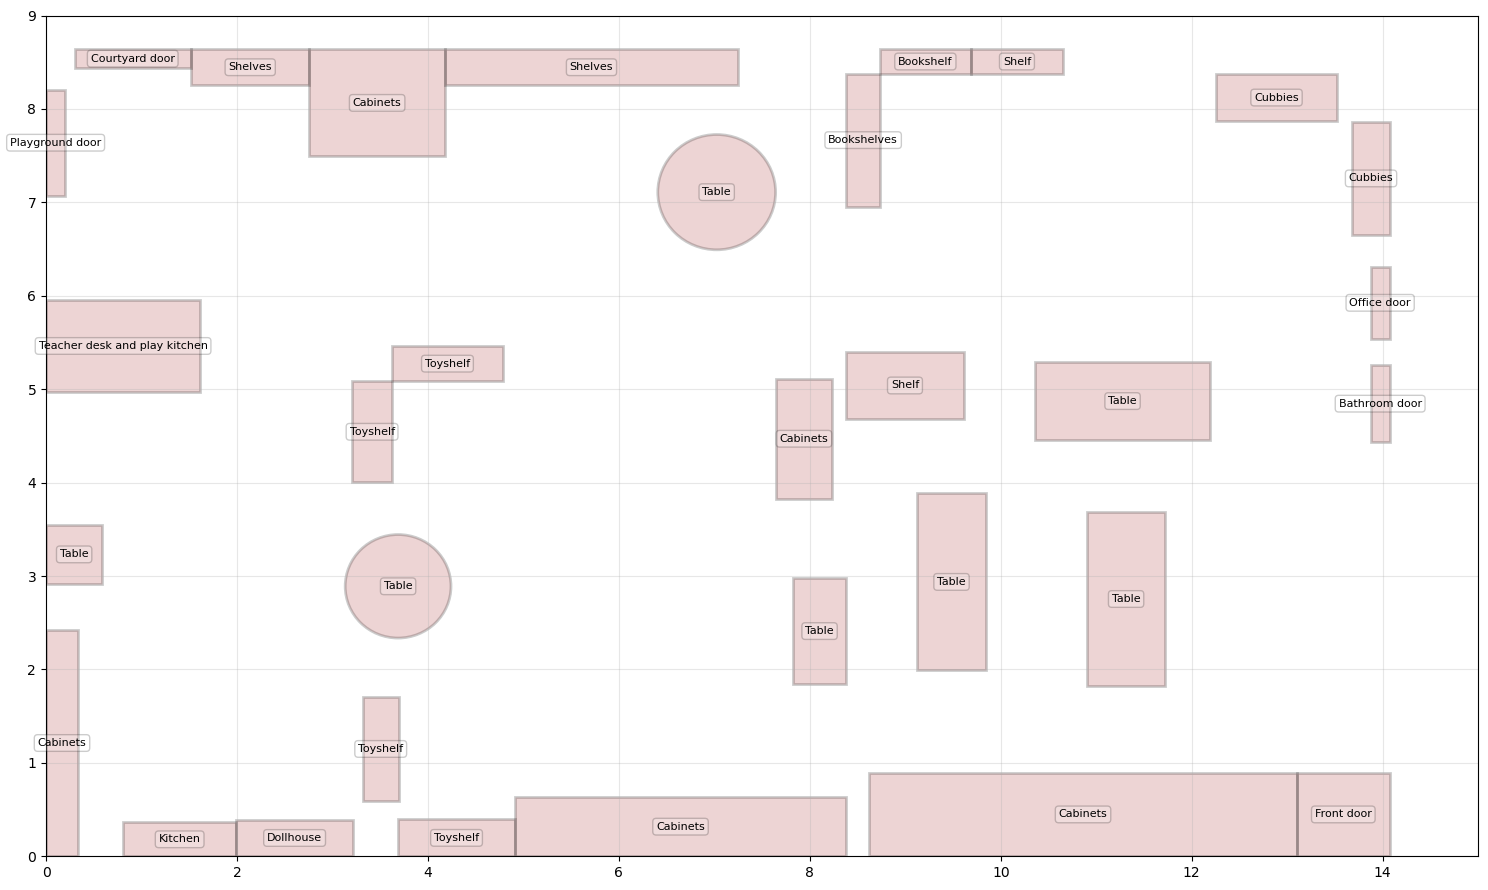

In [23]:
def show_furniture_layout(xlim=(0, 15), ylim=(0, 9)):
    
    furniture_rectangle = [
        {'x': 0, 'y': 0, 'width': 0.334-0, 'height': 2.425-0, 'label': 'Cabinets', 'color': 'brown', 'alpha': 0.2},
        {'x': 0, 'y': 2.918, 'width': 0.588-0, 'height': 3.545-2.918, 'label': 'Table', 'color': 'brown', 'alpha': 0.2},
        {'x': 0, 'y': 4.970, 'width': 1.613-0, 'height': 5.955-4.970, 'label': 'Teacher desk and play kitchen', 'color': 'brown', 'alpha': 0.2},
        {'x': 0.805, 'y': 0, 'width': 1.993-0.805, 'height': 0.363-0, 'label': 'Kitchen', 'color': 'brown', 'alpha': 0.2},
        {'x': 1.993, 'y': 0, 'width': 3.213-1.993, 'height': 0.392-0, 'label': 'Dollhouse', 'color': 'brown', 'alpha': 0.2},
        {'x': 3.688, 'y': 0, 'width': 4.910-3.688, 'height': 0.394-0, 'label': 'Toyshelf', 'color': 'brown', 'alpha': 0.2},
        {'x': 3.316, 'y': 0.596, 'width': 3.694-3.316, 'height': 1.702-0.596, 'label': 'Toyshelf', 'color': 'brown', 'alpha': 0.2},
        {'x': 4.910, 'y': 0, 'width': 8.380-4.910, 'height': 0.634-0, 'label': 'Cabinets', 'color': 'brown', 'alpha': 0.2},
        {'x': 7.823, 'y': 1.845, 'width': 8.380-7.823, 'height': 2.976-1.845, 'label': 'Table', 'color': 'brown', 'alpha': 0.2},
        {'x': 7.640, 'y': 3.827, 'width': 8.236-7.640, 'height': 5.112-3.827, 'label': 'Cabinets', 'color': 'brown', 'alpha': 0.2},
        {'x': 3.209, 'y': 4.004, 'width': 3.620-3.209, 'height': 5.084-4.004, 'label': 'Toyshelf', 'color': 'brown', 'alpha': 0.2},
        {'x': 3.620, 'y': 5.084, 'width': 4.788-3.620, 'height': 5.463-5.084, 'label': 'Toyshelf', 'color': 'brown', 'alpha': 0.2},
        {'x': 8.380, 'y': 4.684, 'width': 9.612-8.380, 'height': 5.395-4.684, 'label': 'Shelf', 'color': 'brown', 'alpha': 0.2}, 
        {'x': 10.354, 'y': 4.457, 'width': 12.196-10.354, 'height': 5.288-4.457, 'label': 'Table', 'color': 'brown', 'alpha': 0.2},
        {'x': 9.124, 'y': 1.990, 'width': 9.843-9.124, 'height': 3.884-1.990, 'label': 'Table', 'color': 'brown', 'alpha': 0.2},
        {'x': 10.904, 'y': 1.826, 'width': 11.720-10.904, 'height': 3.682-1.826, 'label': 'Table', 'color': 'brown', 'alpha': 0.2},
        {'x': 8.621, 'y': 0, 'width': 13.101-8.621, 'height': 0.896-0, 'label': 'Cabinets', 'color': 'brown', 'alpha': 0.2},
        {'x': 1.523, 'y': 8.254, 'width': 2.753-1.523, 'height': 8.638-8.254, 'label': 'Shelves', 'color': 'brown', 'alpha': 0.2},
        {'x': 2.753, 'y': 7.491, 'width': 4.182-2.753, 'height': 8.638-7.491, 'label': 'Cabinets', 'color': 'brown', 'alpha': 0.2},
        {'x': 4.182, 'y': 8.254, 'width': 7.243-4.182, 'height': 8.638-8.254, 'label': 'Shelves', 'color': 'brown', 'alpha': 0.2},
        {'x': 8.380, 'y': 6.955, 'width': 8.736-8.380, 'height': 8.377-6.955, 'label': 'Bookshelves', 'color': 'brown', 'alpha': 0.2},
        {'x': 12.249, 'y': 7.866, 'width': 13.526-12.249, 'height': 8.377-7.866, 'label': 'Cubbies', 'color': 'brown', 'alpha': 0.2},
        {'x': 13.682, 'y': 6.655, 'width': 14.073-13.682, 'height': 7.857-6.655, 'label': 'Cubbies', 'color': 'brown', 'alpha': 0.2},
        {'x': 0, 'y': 7.070, 'width': 0.2, 'height': 8.207-7.070, 'label': 'Playground door', 'color': 'brown', 'alpha': 0.2},
        {'x': 0.298, 'y': 8.638-0.2, 'width': 1.517-0.298, 'height': 0.2, 'label': 'Courtyard door', 'color': 'brown', 'alpha': 0.2},
        {'x': 14.073-0.2, 'y': 5.539, 'width': 0.2, 'height': 6.310-5.539, 'label': 'Office door', 'color': 'brown', 'alpha': 0.2},
        {'x': 14.073-0.2, 'y': 4.434, 'width': 0.2, 'height': 5.256-4.434, 'label': 'Bathroom door', 'color': 'brown', 'alpha': 0.2},
        {'x': 13.101, 'y': 0, 'width': 14.073-13.101, 'height': 0.896, 'label': 'Front door', 'color': 'brown', 'alpha': 0.2},
        {'x': 8.736, 'y': 8.377, 'width': 9.683-8.736, 'height': 8.638-8.377, 'label': 'Bookshelf', 'color': 'brown', 'alpha': 0.2},
        {'x': 9.683, 'y': 8.377, 'width': 14.073-13.101, 'height': 8.638-8.377, 'label': 'Shelf', 'color': 'brown', 'alpha': 0.2},
    ]
    
    furniture_circle = [
        {'x': 3.133+(4.241-3.133)/2, 'y': 2.416+(3.364-2.416)/2, 'r': (4.241-3.133)/2, 'label': 'Table', 'color': 'brown', 'alpha': 0.2},
        {'x': 6.407+(7.641-6.407)/2, 'y': 6.478+(7.740-6.478)/2, 'r': (7.641-6.407)/2, 'label': 'Table', 'color': 'brown', 'alpha': 0.2}
    ]

    fig, ax = plt.subplots(figsize=(15, 9))
    ax.grid(True, alpha=0.3)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    
    for item in furniture_rectangle:
        furniture_rect = Rectangle((item['x'], item['y']), item['width'], item['height'], facecolor=item['color'], alpha=item['alpha'], edgecolor='black', linewidth=2)
        ax.add_patch(furniture_rect)

        center_x = item['x'] + item['width'] / 2
        center_y = item['y'] + item['height'] / 2
        ax.text(center_x, center_y, item['label'], ha='center', va='center', fontsize=8, bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.2))
    
    for item in furniture_circle:
        furniture_circ = Circle((item['x'], item['y']), item['r'], facecolor=item['color'], alpha=item['alpha'], edgecolor='black', linewidth=2)
        ax.add_patch(furniture_circ)

        center_x = item['x'] 
        center_y = item['y']
        ax.text(center_x, center_y, item['label'], ha='center', va='center', fontsize=8, bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.2))
    
    plt.tight_layout()
    plt.show()

show_furniture_layout()